# Same store solution through entity embedding of stores

## Rossmann

Rossmann's Kaggle competition was a business sales prediction competition for $35,000 dollars to the winners.

The premise is that we're given the sales data and information of their stores for the past few years. We need to make a model that can predict the number of sales that will be made in the future.

We can do this through a tabular regression model.

Jeremy walks through feature engineering for this problem, for today though we will download a clean engineered dataset straight from Kaggle. To download it:
1. Go to: https://www.kaggle.com/init27/fastai-v3-rossman-data-clean
2. Go to `output`
3. Right click the download button
4. Click "copy link location" for both train and test
5. `!wget {url}`

(Note: to walk through the feature engineering, see [this](https://github.com/fastai/fastai2/blob/master/nbs/course/rossman_data_clean.ipynb) notebook)

In [4]:
from pathlib import Path

In [5]:
# Setup ggplot graphing system. Done with matplotlib....

import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


In [6]:
DATA_PATH = Path("/home/jupyter/Tabular_project/data")

In [11]:
train = DATA_PATH/"train_clean"
test = DATA_PATH/"test_clean"

And now that we have our data, let's install the `fastai2` library

# Time-Series Analysis

In [8]:
from fastai2.tabular.all import *
from sklearn import manifold


## The Data:

In [9]:
train_df = pd.read_pickle(train)


In [12]:
test_df = pd.read_pickle(test)

In [13]:
test_df.shape, train_df.shape

((41088, 92), (844338, 93))

With our time-series based approach, the feature engineering made a bunch of date-related categorical columns that we can utilize in our **embeddings**.

In [14]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']
   
dep_var = 'Sales'

When doing Regression with these large numbers, we often use the **log** of these values for our `y`'s. Let's transform them real quick:

In [15]:
train_df[dep_var] = np.log(train_df[dep_var])

Now let's declare our `procs`

In [16]:
procs = [FillMissing, Normalize, Categorify]


And splits. Now we want to ensure that (since this is time series) our validation and test 

In [17]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

Let's find that particular index

In [18]:
idx = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

In [19]:
idx

41395

So now our `splits` will be every index *after* the 41395'th item

In [20]:
splits = (L(range(idx, len(train_df))),L(range(idx)))

In [21]:
splits

((#802943) [41395,41396,41397,41398,41399,41400,41401,41402,41403,41404...],
 (#41395) [0,1,2,3,4,5,6,7,8,9...])

Let's make our `TabularPandas`! Since we have a large `DataFrame`, we can enable `inplace` to `True` and `reduce_memory` to `True` to save on some storage space (**Note**: `reduce_memory` is by default `True`). To use `inplace`, we need to set `chained_assignment` to `None` in `pandas`

In [22]:
pd.options.mode.chained_assignment=None

In [23]:
to = TabularPandas(train_df, procs, cat_vars, cont_vars, dep_var, RegressionBlock(), splits=splits, 
                   inplace=True, reduce_memory=True)



And now let's build our `dataloaders`!

In [27]:
dls = to.dataloaders(bs=512)

In [23]:
dls.show_batch()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
0,462,1,2013,11,18,False,24,0,a,a,#na#,2008,1900,ST,47,Rain,5,1,0,0,0,0,1,0,False,False,44319.997768,6.000000,6.0,4.000000,94.0,88.0,74.000001,11.0,6.0,8.0,66.0,65.0,18.000000,-37.000000,8.966612
1,6,4,2015,5,28,False,17,0,a,a,#na#,2013,1900,SN,22,Rain,3,1,0,1,0,0,0,0,False,False,310.000030,20.000000,13.0,6.000000,88.0,53.0,22.999999,21.0,11.0,6.0,63.0,77.0,3.000000,-7.000000,8.466742
2,809,5,2014,5,30,False,24,0,a,a,#na#,2000,1900,NW,22,#na#,4,0,0,1,0,0,0,0,False,False,12770.000191,16.000000,12.0,9.000000,93.0,68.0,41.000000,21.0,11.0,6.0,74.0,71.0,0.999998,-10.000000,9.197762
3,132,2,2013,5,21,False,0,25,d,c,"Jan,Apr,Jul,Oct",1900,2012,BY,21,Rain-Thunderstorm,1,3,0,1,5,1,0,1,False,False,1039.999823,17.000000,11.0,6.000000,100.0,80.0,48.000000,27.0,8.0,5.0,61.0,65.0,0.999998,-9.000001,8.456806
4,111,4,2013,8,29,False,0,25,d,c,"Jan,Apr,Jul,Oct",1900,2009,HE,35,#na#,2,4,0,0,0,0,1,0,False,False,7889.999908,25.000000,18.0,11.000000,100.0,63.0,22.999999,10.0,5.0,3.0,63.0,57.0,91.000001,-35.000000,8.881142
5,460,2,2013,6,18,False,24,0,a,a,#na#,2008,1900,ST,25,#na#,4,2,0,0,0,0,1,0,False,False,34049.998846,30.999999,23.0,15.999999,72.0,53.0,34.000000,11.0,6.0,8.0,56.0,59.0,29.000000,-106.999999,8.243546
6,379,5,2013,5,10,False,0,0,d,a,#na#,1900,1900,"HB,NI",19,Fog-Rain-Thunderstorm,4,0,0,1,1,1,0,1,False,False,6629.999958,18.000000,13.0,8.000000,100.0,68.0,36.000000,32.0,11.0,4.0,61.0,60.0,0.999998,-10.000000,8.302266
7,378,5,2014,3,7,False,18,0,a,c,#na#,2012,1900,NW,10,#na#,1,5,0,0,0,0,1,0,False,False,2140.000020,13.000000,9.0,4.000000,76.0,60.0,37.000000,23.0,14.0,6.0,60.0,55.0,65.000001,-42.000000,8.754161
8,506,5,2014,9,19,False,0,25,a,a,"Feb,May,Aug,Nov",2014,2011,NW,38,Fog-Rain,1,5,0,0,0,0,1,0,False,False,1850.000074,24.000000,20.0,15.999999,94.0,80.0,52.000000,19.0,11.0,5.0,57.0,58.0,91.999999,-13.999999,9.004177
9,854,1,2013,8,26,False,0,25,c,a,"Jan,Apr,Jul,Oct",1900,2010,SN,35,#na#,5,1,0,0,0,4,1,0,False,False,4770.000000,22.000000,17.0,13.000000,72.0,53.0,24.000000,37.0,19.0,7.0,61.0,57.0,88.000001,-38.000000,9.247732


## The Model:


As we're doing regression, we want to dictate what the maximum value to be (and minimum) so we will use a `y_range`

In [24]:
max_log_y = np.max(train_df['Sales'])*1.2

In [25]:
max_log_y

12.7616122408592

And now we can make a `y_range`

In [26]:
y_range = torch.tensor([0, max_log_y]); y_range

tensor([ 0.0000, 12.7616])

Next comes our `Learner`. We'll walk through each step

In [27]:
config=tabular_config( ps = [0.001, 0.01], embed_p= 0.04)

In [28]:
learn = tabular_learner(dls, layers=[1000,500], config = config,
                        y_range=y_range, metrics=exp_rmspe,
                      loss_func=MSELossFlat())

In [35]:
len(cont_vars), len(cat_vars)

(14, 26)

So we have a lot going on right there. `ps` is overall dropout (helps with overfitting), `embed_p` is dropout on the embedding weights, `exp_rmspe` is Root Mean Square Percentage Error

Let's look at our model:

In [36]:
learn.summary()

TabularModel (Input shape: ['512 x 26', '512 x 14'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            512 x 81             90,396     True      
________________________________________________________________
Embedding            512 x 5              40         True      
________________________________________________________________
Embedding            512 x 3              12         True      
________________________________________________________________
Embedding            512 x 7              91         True      
________________________________________________________________
Embedding            512 x 11             352        True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 10             260        True      
_____________________________________________

## Training

Now let's fit!

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0014454397605732083)

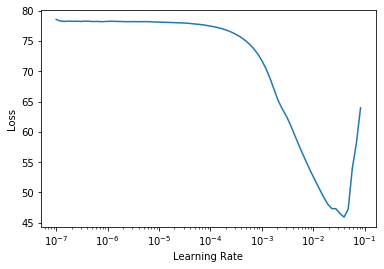

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.055607,0.045648,0.200967,00:39
1,0.055761,0.036815,0.204218,00:39
2,0.040600,0.022283,0.149652,00:38
3,0.031910,0.033056,0.210452,00:38
4,0.024446,0.024577,0.148640,00:38
5,0.021746,0.021414,0.165028,00:38
6,0.016653,0.018606,0.131078,00:38
7,0.012837,0.013640,0.124859,00:38
8,0.010578,0.012028,0.113432,00:38
9,0.009307,0.011754,0.111463,00:39


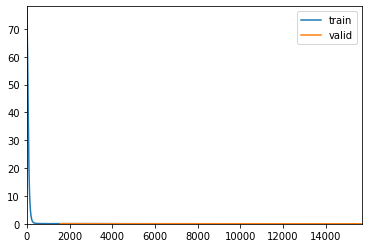

In [29]:
learn.fit_one_cycle(10, 3e-3, wd=0.2, cbs=[SaveModelCallback(), ShowGraphCallback()])

For comparison, an `exp_rmspe` of 0.108 was 10th place

### Let's see how does the model generalize to the testing set on Kaggle

In [35]:
learn.export("DL_model")

In [338]:
dl = learn.dls.test_dl(test_df)

#We need to tell the `Learner` to return the predictions for the test set we added

raw_test_preds = learn.get_preds(dl=dl)

test_preds = np.exp(raw_test_preds[0]).numpy().flatten()

test_df['Sales'] = test_preds
test_df1 = test_df.copy()
test_df1['Sales'] = test_preds

test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission.csv', index=False)

In [374]:
test_df1   #Its sales is not logged

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,Sales
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,4056.798096
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,6797.027832
2,2,3,7,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,9932.955078
3,3,4,8,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,6227.965332
4,4,5,9,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,6329.505371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41083,41084,1111,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,2888.308350
41084,41084,41085,1112,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,8266.749023
41085,41085,41086,1113,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,7107.162598
41086,41086,41087,1114,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,23969.957031


We would land on the 10th spot on the private leaderboard!

## Let's try to see if similar store solution would help our predictions

In [71]:
# figure out stores and its state affiliations
store_state = train_df[["Store", "State"]]

store_2state = []
for i, m in store_state.groupby("Store"):
     store_2state.append(m.State.mode().values[0]) # of length 1115


states_names = ["#NA#", 'Berlin', 'Baden Wuerttemberg', 'Bayern', 'Niedersachsen/Bremen', 
                'Hessen', 'Hamburg', 'Nordrhein Westfalen', 'Rheinland Pfalz',
                'Schleswig Holstein', 'Sachsen', 'Sachsen Anhalt', 'Thueringen']

state_2statenames_dict = {i:j for i, j in zip(learn.dls.train_ds.classes["State"],states_names)}

store_2statenames = [state_2statenames_dict[i] for i in store_2state]

In [65]:
weight_matrix_store = learn.model.embeds[0].weight.cpu().detach().numpy()

In [66]:
train_df.head(20)

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,8.568456,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,8.710125,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,9.025696,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,9.546455,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,8.480944,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
5,5,6,5,2015-07-31,8.639588,589,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
6,6,7,5,2015-07-31,9.638480,1414,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
7,7,8,5,2015-07-31,9.046880,833,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
8,8,9,5,2015-07-31,9.055439,687,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
9,9,10,5,2015-07-31,8.879751,681,1,1,False,1,...,67,0,0,0,7.0,0.0,5.0,7.0,0.0,5.0


In [73]:
# Some functions to get KNN 
# Borrowed code from https://github.com/fastai/fastai/blob/master/courses/dl2/devise.ipynb
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=4, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [74]:
knn_indices = create_index(weight_matrix_store)

In [99]:
#find out the top three similar stores for every store
# Creat a dictionary mapping from store to closest 3 stores
stores, _ = list(get_knns(knn_indices, weight_matrix_store))
stores_3 = [stores[i][1:] for i in range(len(stores))]
close_store_dict = { i:list(j) for i,j in enumerate(stores_3)}
close_store_dict

{0: [399, 394, 1061],
 1: [912, 31, 811],
 2: [1069, 969, 642],
 3: [792, 153, 759],
 4: [104, 464, 527],
 5: [425, 1035, 828],
 6: [48, 257, 839],
 7: [1101, 729, 906],
 8: [265, 581, 404],
 9: [540, 29, 890],
 10: [511, 9, 112],
 11: [248, 862, 914],
 12: [1079, 731, 909],
 13: [795, 188, 1004],
 14: [276, 566, 1098],
 15: [139, 1062, 959],
 16: [168, 880, 901],
 17: [798, 779, 933],
 18: [329, 236, 401],
 19: [374, 996, 236],
 20: [914, 381, 665],
 21: [127, 701, 636],
 22: [879, 688, 1065],
 23: [312, 875, 242],
 24: [372, 71, 674],
 25: [125, 1033, 817],
 26: [508, 652, 185],
 27: [71, 380, 400],
 28: [949, 649, 460],
 29: [273, 540, 791],
 30: [563, 40, 829],
 31: [702, 1, 443],
 32: [970, 764, 899],
 33: [599, 1021, 525],
 34: [148, 349, 738],
 35: [545, 380, 608],
 36: [868, 1092, 539],
 37: [484, 468, 802],
 38: [244, 127, 627],
 39: [881, 664, 419],
 40: [563, 330, 114],
 41: [884, 457, 288],
 42: [697, 64, 769],
 43: [62, 1072, 617],
 44: [949, 735, 565],
 45: [874, 239, 285

In [311]:
close_store_index_df = train_df.Store.map(close_store_dict)
close_store_index_df = pd.DataFrame(close_store_index_df)

close_stores_df_three_col = pd.DataFrame(close_store_index_df['Store'].values.tolist(), 
                                         columns=['Similar1','Similar2','Similar3'])

close_stores_df_three_col["Date"] = train_df.Date

In [312]:
# create a look up table from train_df

train_lookup = train_df[["Store", "Date", "Sales"]]

In [313]:
similar_1 = close_stores_df_three_col[["Similar1", "Date"]]
similar_1.columns = ["Store", "Date"]

similar_2 = close_stores_df_three_col[["Similar2", "Date"]]
similar_2.columns = ["Store", "Date"]


similar_3 = close_stores_df_three_col[["Similar3", "Date"]]
similar_3.columns = ["Store", "Date"]

In [314]:
def similar_look_up(similar_col):
    return pd.merge(similar_col, train_lookup, on= ["Store", "Date"], how='left')["Sales"]

In [315]:
similar_1_sales = similar_look_up(similar_1)
similar_2_sales = similar_look_up(similar_2)
similar_3_sales = similar_look_up(similar_3)


In [316]:
sum(pd.isna(similar_1_sales)), sum(pd.isna(similar_2_sales)), sum(pd.isna(similar_3_sales)), 

(18410, 20811, 18213)

In [317]:
similar_df = pd.DataFrame({"similar_1": similar_1_sales ,
                         "similar_2": similar_2_sales ,
                         "similar_3": similar_3_sales })

In [318]:
full_train_df = pd.concat((train_df, similar_df), axis=1)

In [319]:
full_train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,similar_1,similar_2,similar_3
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,0,5.0,0.0,5.0,7.0,0.0,5.0,6864.0,7248.0,5235.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,0,5.0,0.0,5.0,1.0,0.0,1.0,7746.0,5280.0,3671.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,0,5.0,0.0,5.0,5.0,0.0,5.0,10181.0,8392.0,11253.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,0,5.0,0.0,5.0,1.0,0.0,1.0,10483.0,11967.0,14510.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,0,5.0,0.0,5.0,1.0,0.0,1.0,4744.0,5853.0,8019.0


In [400]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'similar_1', 'similar_2', 'similar_3']
   
dep_var = 'Sales'

In [401]:
full_train_df[dep_var] = np.log(full_train_df[dep_var])
full_train_df['similar_1'] = np.log(full_train_df['similar_1'])
full_train_df['similar_2'] = np.log(full_train_df['similar_2'])
full_train_df['similar_3'] = np.log(full_train_df['similar_3'])

In [402]:
to = TabularPandas(full_train_df, procs, cat_vars, cont_vars, dep_var, RegressionBlock(), splits=splits, 
                   inplace=True, reduce_memory=True)

In [403]:
dls = to.dataloaders(bs=512)

In [404]:
learn_with_similar = tabular_learner(dls, layers=[1000,500], config = config,
                        y_range=y_range, metrics=exp_rmspe,
                      loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.0008317637839354575)

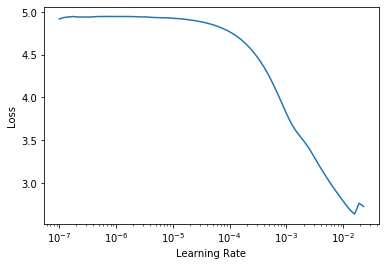

In [330]:
learn_with_similar.lr_find()

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.000815,0.001050,0.033168,00:40
1,0.000146,0.000112,0.010498,00:39
2,0.000055,0.000039,0.006266,00:39
3,0.000037,0.000033,0.005774,00:39


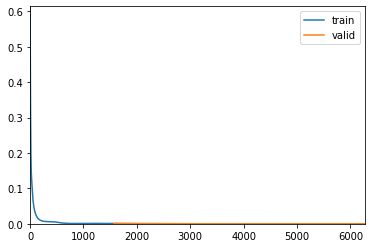

In [405]:
learn_with_similar.fit_one_cycle(4, 3e-3, wd=0.2, cbs=[ShowGraphCallback()])

In [332]:
learn_with_similar.export("Model_with_similar_log")

### Create the testing df containing the similar store sales

In [339]:
close_store_index_df = test_df1.Store.map(close_store_dict)
close_store_index_df = pd.DataFrame(close_store_index_df)

close_stores_df_three_col = pd.DataFrame(close_store_index_df['Store'].values.tolist(), 
                                         columns=['Similar1','Similar2','Similar3'])

close_stores_df_three_col["Date"] = test_df1.Date

In [342]:
close_stores_df_three_col

,Similar1,Similar2,Similar3,Date
0,912,31,811,2015-09-17
1,792,153,759,2015-09-17
2,1101,729,906,2015-09-17
3,265,581,404,2015-09-17
4,540,29,890,2015-09-17
...,...,...,...,...
41083,1109,165,619,2015-08-01
41084,753,1086,308,2015-08-01
41085,1037,359,943,2015-08-01
41086,251,523,595,2015-08-01


In [377]:
test_lookup = test_df1[["Store", "Date", "Sales"]]

In [378]:
test_lookup

,Store,Date,Sales
0,1,2015-09-17,4056.798096
1,3,2015-09-17,6797.027832
2,7,2015-09-17,9932.955078
3,8,2015-09-17,6227.965332
4,9,2015-09-17,6329.505371
...,...,...,...
41083,1111,2015-08-01,2888.308350
41084,1112,2015-08-01,8266.749023
41085,1113,2015-08-01,7107.162598
41086,1114,2015-08-01,23969.957031


In [379]:
test_lookup["Sales"] = np.log(test_lookup["Sales"])

In [380]:
similar_1 = close_stores_df_three_col[["Similar1", "Date"]]
similar_1.columns = ["Store", "Date"]

similar_2 = close_stores_df_three_col[["Similar2", "Date"]]
similar_2.columns = ["Store", "Date"]


similar_3 = close_stores_df_three_col[["Similar3", "Date"]]
similar_3.columns = ["Store", "Date"]

In [381]:
def similar_look_up(similar_col, look_up_df):
    return pd.merge(similar_col, look_up_df, on= ["Store", "Date"], how='left')["Sales"]

In [382]:
similar_1_sales = similar_look_up(similar_1, test_lookup)
similar_2_sales = similar_look_up(similar_2, test_lookup)
similar_3_sales = similar_look_up(similar_3, test_lookup)

In [383]:
sum(pd.isna(similar_1_sales)), sum(pd.isna(similar_2_sales)), sum(pd.isna(similar_3_sales)), 

(4464, 6960, 7296)

In [384]:
similar_df = pd.DataFrame({"similar_1": similar_1_sales,
                         "similar_2": similar_2_sales,
                         "similar_3": similar_3_sales })

In [385]:
similar_df

,similar_1,similar_2,similar_3
0,8.547294,8.660028,8.225689
1,8.985062,8.899048,8.883410
2,9.269079,9.212188,9.287025
3,8.703329,8.627860,8.675185
4,8.830178,8.885152,8.839469
...,...,...,...
41083,8.551827,8.358891,8.186654
41084,9.029499,8.589791,9.010313
41085,8.815715,9.059769,8.901046
41086,9.925444,NaN,NaN


In [394]:
full_test_df = pd.concat((test_df1, similar_df), axis=1)

In [396]:
full_test_df.drop("Sales", axis= 1, inplace = True)

In [397]:
full_test_df

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,similar_1,similar_2,similar_3
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.547294,8.660028,8.225689
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.985062,8.899048,8.883410
2,2,3,7,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,9.269079,9.212188,9.287025
3,3,4,8,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.703329,8.627860,8.675185
4,4,5,9,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.830178,8.885152,8.839469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41083,41084,1111,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,8.551827,8.358891,8.186654
41084,41084,41085,1112,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,9.029499,8.589791,9.010313
41085,41085,41086,1113,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,8.815715,9.059769,8.901046
41086,41086,41087,1114,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,9.925444,NaN,NaN


In [389]:
learn_with_similar = load_learner('Model_with_similar_log')

In [398]:
dl = learn_with_similar.dls.test_dl(full_test_df)

#We need to tell the `Learner` to return the predictions for the test set we added

raw_test_preds = learn_with_similar.get_preds(dl=dl)

test_preds = np.exp(raw_test_preds[0]).numpy().flatten()

test_df['Sales'] = test_preds
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_with_similar.csv', index=False)

In [399]:
raw_test_preds

(tensor([[2.1254],
         [2.1857],
         [2.2157],
         ...,
         [2.1685],
         [2.2816],
         [2.2077]]), None)

tensor([[7.8057],
        [8.0750],
        [8.0757],
        ...,
        [7.9644],
        [9.1965],
        [8.1274]])

In [137]:
# The following function tooooo slow
# Use merge method istead for matching  multiple columns


# # Next is to find out the mean value of sales 
# def mean_sale_finder(series_similar_store):
#     ls = []
#     for i,j in enumerate(series_similar_store):  # i here refers to the index of the train_df
#         ls.append(train_df.loc[((train_df.Store == j) & (train_df.Date == train_df.Date[i])), "Sales"])
#     return ls



# Try XGBoost

In [24]:
import xgboost as xgb
from bayes_opt import BayesianOptimization


XGBoost does not handle categorical variable nicely. You need to either preprocess the catgorical vars through one hot encoding, and concatenate to the original dataset; or just let the model treats categorical integers as numerical variable

In [25]:
# Let's define the loss funtion here
def exp_rmspe(pred, targ):
    "Exp RMSE between `pred` and `targ`."
    pred, targ = np.exp(pred), np.exp(targ)
    pct_var = (targ - pred)/targ
    return np.sqrt((pct_var**2).mean())

In [26]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [27]:
index = np.random.choice(np.array(range(41396, X_train.shape[0] )), 200000)
X_train_sample = X_train.loc[index]
y_train_sample = y_train[index]

In [28]:
X_train_sample

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday
527779,57,5,1,12,6,1,1,1,4,3,...,0.877884,-0.111221,0.122481,2.705215,3.881814,0.255604,1.854770,1.463722,-0.701135,0.599161
183310,413,4,3,1,15,1,5,1,1,3,...,0.877884,0.885645,0.529760,-1.065403,-1.152075,0.255604,0.042582,-0.374736,-0.922376,-1.218356
172665,945,2,3,1,27,1,25,1,1,3,...,0.877884,0.578917,0.427940,-0.178199,0.190296,-1.594353,-0.772903,0.706710,-0.385078,-0.848691
585823,753,1,1,10,7,1,11,26,4,3,...,0.615005,0.042143,-0.590257,-1.065403,-1.152075,-1.594353,-0.954122,-1.023604,-1.080405,0.414329
88298,465,1,3,4,27,1,25,1,4,3,...,0.877884,1.039009,0.987948,0.709005,-0.145297,0.872256,1.129895,0.814854,-0.543107,1.061242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441803,924,2,2,3,11,1,25,26,1,1,...,-0.042192,-0.264585,-0.641166,0.709005,0.693685,0.255604,0.314410,0.490420,0.973970,0.013859
407999,636,2,2,4,15,1,25,26,3,1,...,-0.830828,-0.341267,0.326120,0.487204,1.532666,0.255604,-1.316560,-1.023604,1.922143,1.092047
777342,805,3,1,3,13,1,18,1,4,1,...,-0.042192,1.039009,1.547956,-0.400000,0.190296,0.255604,0.133191,-0.374736,0.879152,0.691577
140855,356,6,3,2,28,1,25,26,4,3,...,-0.042192,0.272189,-0.132068,-0.400000,-0.313093,-0.977701,1.129895,0.598565,0.468278,0.137081


In [29]:
learn = load_learner('DL_model')
dl = learn.dls.test_dl(test_df)

In [30]:
processed_test_df = dl.xs 
processed_test_df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday
0,1,4,3,9,17,1,25,1,3,1,...,0.877884,1.575783,1.904325,0.709005,0.358092,0.255604,0.405019,0.165987,2.111777,1.184463
1,3,4,3,9,17,1,25,26,1,1,...,0.877884,0.272189,0.377030,1.596209,2.371647,0.255604,0.314410,0.165987,2.111777,1.184463
2,7,4,3,9,17,1,25,1,1,3,...,0.352126,-0.111221,0.529760,0.709005,0.358092,-0.361048,-0.501075,0.165987,2.427835,1.184463
3,8,4,3,9,17,1,12,1,1,1,...,0.352126,-0.111221,0.529760,0.709005,0.358092,-0.361048,-0.501075,0.165987,2.427835,1.184463
4,9,4,3,9,17,1,25,1,1,3,...,0.877884,0.272189,0.377030,1.596209,2.371647,0.255604,0.314410,0.165987,2.111777,1.184463


In [44]:
def fit_with(max_depth:float, gamma:float, n_estimators:float,learning_rate:float):
    max_depth = int(max_depth) # Turn this into int, otherwise it will not work! 
    n_estimators = int(n_estimators) # Turn this into int, otherwise it will not work!
    model = xgb.XGBRegressor(n_estimators = n_estimators, max_depth= max_depth, 
                             learning_rate=learning_rate, gamma = gamma)
    xgb_model = model.fit(X_train, y_train)
    pred = xgb_model.predict(X_valid)
  
    return -float(exp_rmspe(pred, y_valid))

In [45]:
params = {'max_depth': (3, 10), 
          'gamma': (0, 1),
          'learning_rate': (0, 1),
          'n_estimators': (100, 120)}

In [46]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = params)

In [47]:
optim.maximize(n_iter = 10)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.3409   |  0.02869  |  0.1124   |  4.044    |  102.2    |
|  2        | -0.2498   |  0.1817   |  0.5732   |  3.104    |  116.2    |
|  3        | -0.1684   |  0.1874   |  0.9535   |  5.744    |  109.1    |
|  4        | -0.2702   |  0.3047   |  0.263    |  4.735    |  108.4    |
|  5        | -0.2004   |  0.9627   |  0.595    |  4.728    |  116.7    |
|  6        | -0.2825   |  0.0      |  1.0      |  10.0     |  120.0    |
|  7        | -0.2118   |  1.0      |  1.0      |  10.0     |  100.0    |
|  8        | -0.2118   |  1.0      |  1.0      |  10.0     |  111.4    |
|  9        | -0.2643   |  1.0      |  1.0      |  3.0      |  120.0    |
|  10       | -0.2802   |  0.0      |  1.0      |  10.0     |  104.8    |
|  11       | -0.2697   |  1.0      |  1.0      |  3.0      |  111.6    |
|  12       | -0.2066   |  0.0      | 

In [48]:
optim.max

{'target': -0.16837753412323578,
 'params': {'gamma': 0.18737473609037647,
  'learning_rate': 0.95346399864783,
  'max_depth': 5.744014828349802,
  'n_estimators': 109.11975197901292}}

In [52]:
model = xgb.XGBRegressor(n_estimators = 110, max_depth=6, learning_rate=0.9534, subsample=0.5)

In [54]:
xgb_model = model.fit(X_train, y_train)

In [55]:
pred = model.predict(processed_test_df)

test_preds = np.exp(pred)
test_preds_xgboost

In [62]:
test_df['Sales'] = test_preds
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_xgboost.csv', index=False)

XGBOOST alone leads to a 0.20 rmspe which leads us to the 2714th place in the leader board compared with the first DL model which leads to a 0.10 rmspe, 10th place on the leader board.

# Try lightgbm

Lightgbm could handle categorical variable by taking the "categorical_feature" arguments in its Dataset and also its Training API. 

In [92]:
import lightgbm as lgb


In [103]:
train_lgb = lgb.Dataset(X_train,  categorical_feature= cat_vars, label=y_train)
valid_lgb = lgb.Dataset(X_valid, categorical_feature= cat_vars, label = y_valid)

In [125]:
def fit_with(max_depth:int,  n_estimators:int, learning_rate:float, num_leaves: int, 
            bagging_fraction:float, feature_fraction:float):
    max_depth = int(max_depth) # Turn this into int, otherwise it will not work! 
    n_estimators = int(n_estimators) # Turn this into int, otherwise it will not work!
    num_leaves = int(num_leaves)
    model = lgb.LGBMRegressor(n_estimators = n_estimators, max_depth= max_depth, 
                             learning_rate=learning_rate, bagging_fraction = bagging_fraction,
                             feature_fraction = feature_fraction, num_leaves = num_leaves)
    lgb_model = model.fit(X_train, y_train)
    pred = lgb_model.predict(X_valid)
  
    return -float(exp_rmspe(pred, y_valid))

In [126]:
params = {"max_depth": (25, 75),
              "learning_rate" : (0.001, 1),
              "num_leaves": (200, 1200),
              "n_estimators": (200, 500),
          "feature_fraction": (0.5, 1),
          'bagging_fraction': (0.5, 1)
             }

In [127]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = params)

In [128]:
optim.maximize(n_iter = 25, init_points= 10)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        | -0.1841   |  0.5083   |  0.9482   |  0.6501   |  33.15    |  274.1    |  1.138e+0 |
|  2        | -0.1447   |  0.7658   |  0.8587   |  0.3432   |  38.82    |  492.4    |  241.8    |
|  3        | -0.17     |  0.9099   |  0.8267   |  0.7683   |  25.6     |  237.7    |  636.1    |
|  4        | -0.2142   |  0.5461   |  0.5054   |  0.856    |  44.1     |  244.5    |  727.5    |
|  5        | -0.1704   |  0.5214   |  0.6506   |  0.5602   |  56.26    |  368.8    |  938.9    |
|  6        | -0.1744   |  0.7082   |  0.5191   |  0.581    |  32.97    |  484.4    |  773.1    |
|  7        | -0.2162   |  0.765    |  0.5371   |  0.6829   |  69.73    |  341.3    |  469.7    |
|  8        | -0.1292   |  0.8976   |  0.8573   |  0.06544  |  25.26    |  268.6    |  428.7    |
|  9        | -0.169

In [132]:
optim.max

{'target': -0.12444423787525713,
 'params': {'bagging_fraction': 0.8735517297826776,
  'feature_fraction': 0.7403032052745127,
  'learning_rate': 0.037262515871608407,
  'max_depth': 73.561920263003,
  'n_estimators': 400.53632637344083,
  'num_leaves': 1199.5316871516538}}

In [134]:
parameters = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 1200,
    'bagging_fraction': 0.8735517297826776,
     'feature_fraction': 0.7403032052745127,
     'learning_rate': 0.037262515871608407,
     'max_depth': 73,
     'n_estimators': 400,
}

In [135]:
model = lgb.train(parameters,
                       train_lgb,
                       valid_sets= valid_lgb,
                       num_boost_round=5000,
                       early_stopping_rounds=100,
                 categorical_feature= cat_vars)

[1]	valid_0's l2: 0.16186
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.157169
[3]	valid_0's l2: 0.147596
[4]	valid_0's l2: 0.140859
[5]	valid_0's l2: 0.134387
[6]	valid_0's l2: 0.127737
[7]	valid_0's l2: 0.120155
[8]	valid_0's l2: 0.115423
[9]	valid_0's l2: 0.108742
[10]	valid_0's l2: 0.102377
[11]	valid_0's l2: 0.0981108
[12]	valid_0's l2: 0.0927356
[13]	valid_0's l2: 0.0876522
[14]	valid_0's l2: 0.084382
[15]	valid_0's l2: 0.079633
[16]	valid_0's l2: 0.0754538
[17]	valid_0's l2: 0.0729134
[18]	valid_0's l2: 0.0693544
[19]	valid_0's l2: 0.0669124
[20]	valid_0's l2: 0.0635977
[21]	valid_0's l2: 0.0615144
[22]	valid_0's l2: 0.0586236
[23]	valid_0's l2: 0.0558023
[24]	valid_0's l2: 0.0532916
[25]	valid_0's l2: 0.0509782
[26]	valid_0's l2: 0.0497203
[27]	valid_0's l2: 0.0475759
[28]	valid_0's l2: 0.0465529
[29]	valid_0's l2: 0.0453417
[30]	valid_0's l2: 0.0435883
[31]	valid_0's l2: 0.0419157
[32]	valid_0's l2: 0.0410887
[33]	valid_0's l2: 0.0400322
[34

[277]	valid_0's l2: 0.013435
[278]	valid_0's l2: 0.0134301
[279]	valid_0's l2: 0.0134289
[280]	valid_0's l2: 0.0134199
[281]	valid_0's l2: 0.0134144
[282]	valid_0's l2: 0.0134072
[283]	valid_0's l2: 0.0134053
[284]	valid_0's l2: 0.0134049
[285]	valid_0's l2: 0.0134019
[286]	valid_0's l2: 0.0133933
[287]	valid_0's l2: 0.0133885
[288]	valid_0's l2: 0.013386
[289]	valid_0's l2: 0.0133798
[290]	valid_0's l2: 0.0133707
[291]	valid_0's l2: 0.0133557
[292]	valid_0's l2: 0.0133478
[293]	valid_0's l2: 0.0133463
[294]	valid_0's l2: 0.0133444
[295]	valid_0's l2: 0.0133405
[296]	valid_0's l2: 0.0133375
[297]	valid_0's l2: 0.0133366
[298]	valid_0's l2: 0.0133288
[299]	valid_0's l2: 0.0133233
[300]	valid_0's l2: 0.0133212
[301]	valid_0's l2: 0.0133181
[302]	valid_0's l2: 0.0133111
[303]	valid_0's l2: 0.0133018
[304]	valid_0's l2: 0.0133003
[305]	valid_0's l2: 0.0132966
[306]	valid_0's l2: 0.0132949
[307]	valid_0's l2: 0.013289
[308]	valid_0's l2: 0.0132869
[309]	valid_0's l2: 0.0132865
[310]	valid_0

In [136]:
pred = model.predict(processed_test_df, categorical_feature = cat_vars)

In [137]:
test_preds_lightgbm = np.exp(pred)


In [138]:
test_df['Sales'] = test_preds_lightgbm
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_lightgbm_finetuned.csv', index=False)

# Try Catboost

# Now Let's try out visualizing embedding space via dimension reduction techniques


In [66]:
weight_matrix_store = learn.model.embeds[0].weight.cpu().detach().numpy()
weight_pca = learn.model.embeds[0].weight.cpu().detach().pca()

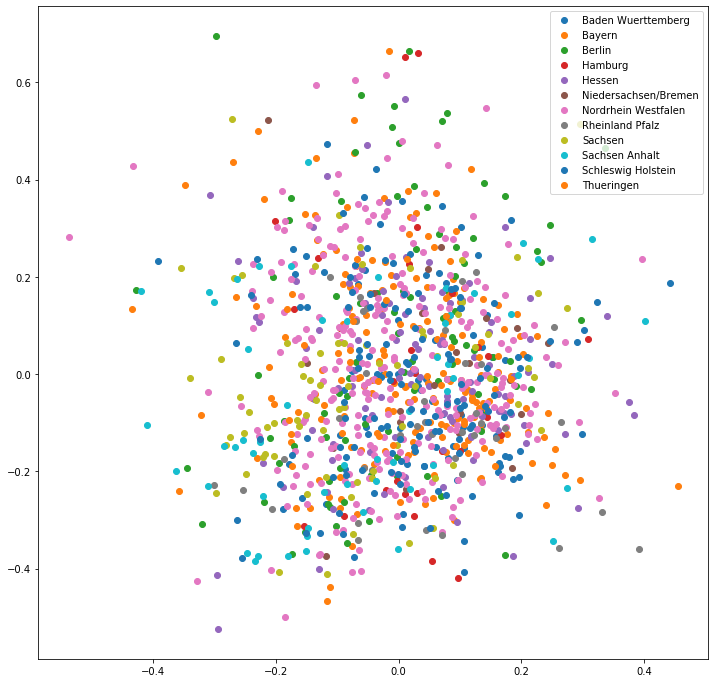

In [45]:
## Dimention recudtion using PCA

X = weight_pca[1:,1] # to remove the first category: the na class
Y = weight_pca[1:,0]
store_state_color_df = pd.DataFrame({"X":X,
                                     "Y":Y,
                                     "statename": store_2statenames})

plt.figure(figsize=(12,12))
groups = store_state_color_df.groupby("statename")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)
plt.legend()
plt.show()


# plt.figure(figsize=(12,12))
# plt.scatter(X, Y)
# for i, x, y in zip(learn.dls.train_ds.classes["Store"], X, Y):
#     plt.text(x,y,i, color=store_2statenames, fontsize=13)
# plt.show()

In [68]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100, verbose=2, early_exaggeration=1)
t_matrix = tsne.fit_transform(weight_matrix_store)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1116
[t-SNE] Computed conditional probabilities for sample 1116 / 1116
[t-SNE] Mean sigma: 0.073601
[t-SNE] Iteration 50: error = 2.4050751, gradient norm = 0.0042778 (50 iterations in 2.553s)
[t-SNE] Iteration 100: error = 2.0195678, gradient norm = 0.0023634 (50 iterations in 2.568s)
[t-SNE] Iteration 150: error = 1.8550226, gradient norm = 0.0016023 (50 iterations in 2.521s)
[t-SNE] Iteration 200: error = 1.7577801, gradient norm = 0.0012167 (50 iterations in 2.566s)
[t-SNE] Iteration 250: error = 1.6921197, gradient norm = 0.0009055 (50 iterations in 2.559s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.692120
[t-SNE] Iteration 300: error = 1.6492261, gradient norm = 0.0006199 (50 iterations in 2.530s)
[t-SNE] Iteration 350: error = 1.5820118, gradient norm = 0.0004701 (50 iterations in 2.537s)
[t-SNE] Iteration 400: error = 1.5324210, gradient norm = 0.00036

In [69]:
t_matrix

array([[-19.138529 ,  -6.891047 ],
       [ -9.382007 , -38.269444 ],
       [-31.335117 ,  16.397568 ],
       ...,
       [ -6.4089365, -20.16972  ],
       [100.405205 , -25.988102 ],
       [-21.250744 , -49.737694 ]], dtype=float32)

In [105]:
# Data reduction using t-SNE

X = t_matrix[1:, 0] # ommit the first category: NA class
Y = t_matrix[1:, 1]

store_state_color_df = pd.DataFrame({"X":X,
                                     "Y":Y,
                                     "statename": store_2statenames,
                                   "store_idx": list(learn.dls.train_ds.classes["Store"][1:])})



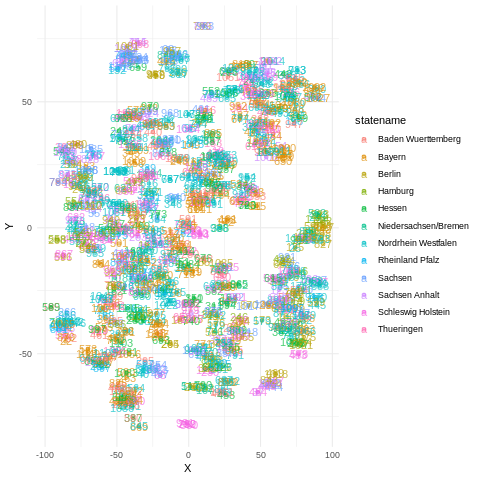

In [110]:
%%R 
# load the ggplot2 library
library(ggplot2)

p = ggplot(
store_state_color_df, aes(x= X, y= Y, color = statename))+
    geom_point(alpha = 0.5)+
    geom_text(aes(label = store_idx), alpha = 0.7)+
    theme_minimal()
p

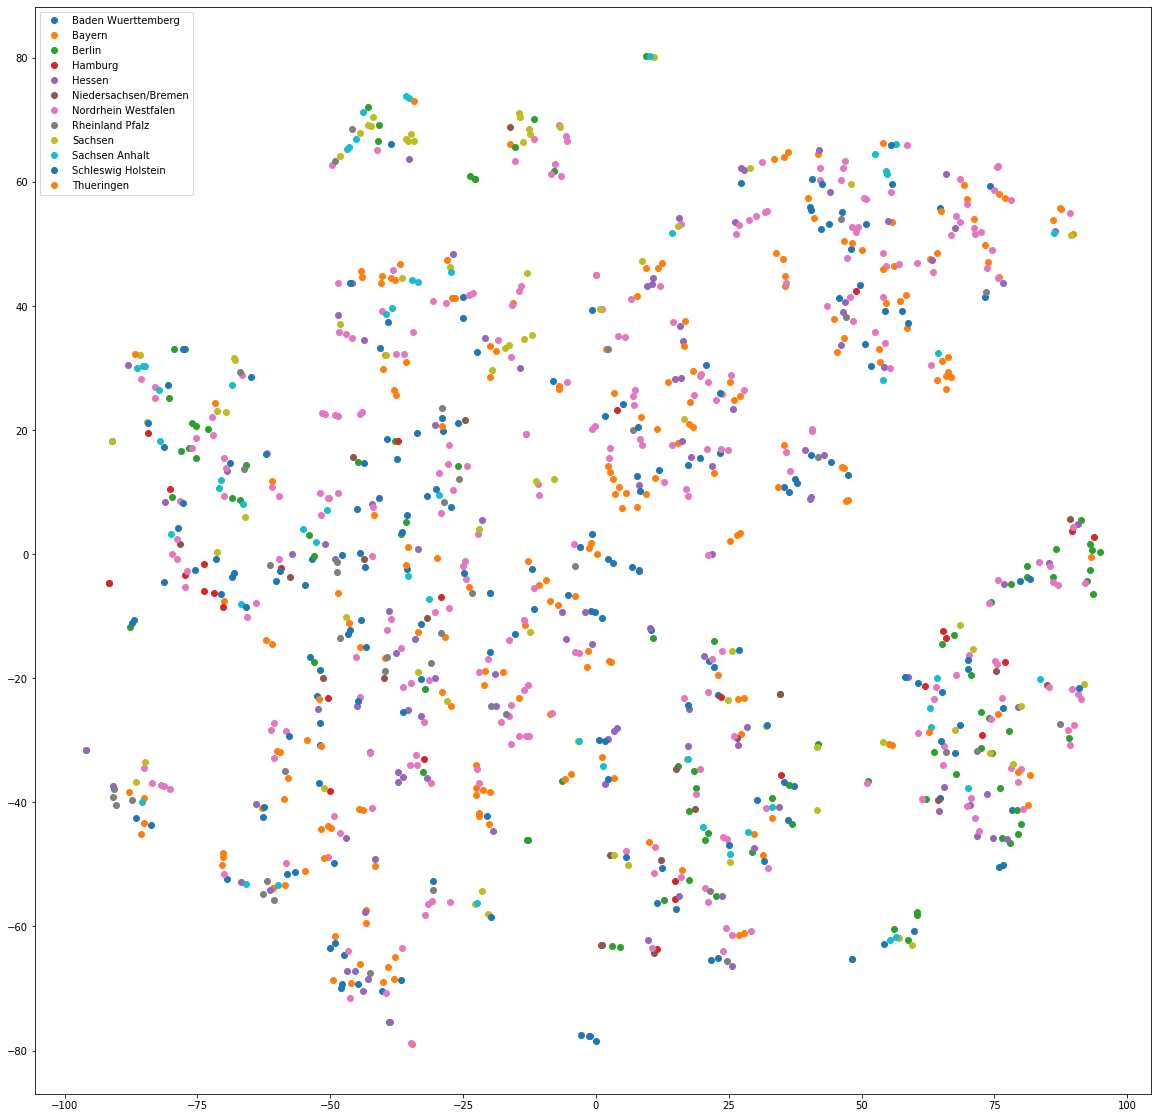

In [81]:


groups = store_state_color_df.groupby("statename")


plt.figure(figsize=(20,20))


for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)


plt.legend()
plt.show()


# plt.scatter(-Y[:, 0], -Y[:, 1])
# for i, txt in enumerate(names):
#     plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))
#plt.savefig('store_embedding.png')

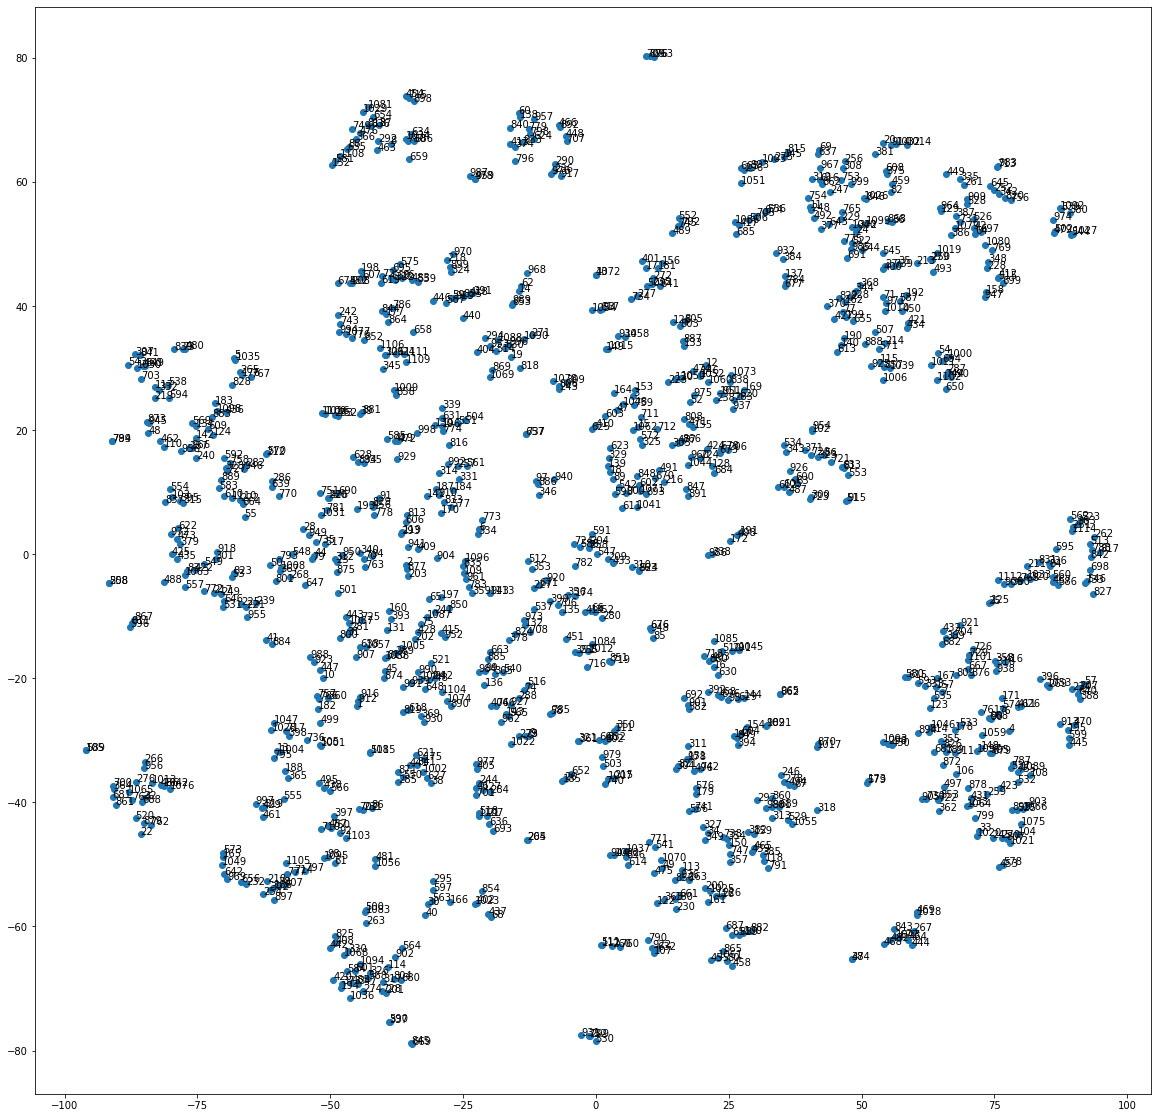

In [77]:
plt.figure(figsize=(20,20))

plt.scatter(X, Y)

for x, y, txt in zip(X, Y, list(learn.dls.train_ds.classes["Store"])[1:]):
    plt.annotate(str(txt), (x,y))


plt.show()

In [84]:
store_state_color_df

,X,Y,statename
0,-45.034454,-24.552702,Hessen
1,-35.684532,-1.676102,Thueringen
2,7.024644,25.504971,Nordrhein Westfalen
3,77.710770,-28.505589,Berlin
4,-68.089760,31.685863,Sachsen
...,...,...,...
1110,-36.095757,32.213425,Nordrhein Westfalen
1111,75.725319,-4.140266,Nordrhein Westfalen
1112,-19.894022,-6.311983,Schleswig Holstein
1113,89.561646,3.663664,Hamburg


## 3D T-sne visulization of stores

In [70]:
tsne = manifold.TSNE(n_components=3 ,init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100, verbose=2, early_exaggeration=1)
t_matrix = tsne.fit_transform(weight_matrix_store)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1116
[t-SNE] Computed conditional probabilities for sample 1116 / 1116
[t-SNE] Mean sigma: 0.073601
[t-SNE] Iteration 50: error = 2.0031426, gradient norm = 0.0021114 (50 iterations in 4.669s)
[t-SNE] Iteration 100: error = 1.6301577, gradient norm = 0.0007029 (50 iterations in 4.653s)
[t-SNE] Iteration 150: error = 1.4929931, gradient norm = 0.0003984 (50 iterations in 4.648s)
[t-SNE] Iteration 200: error = 1.4221860, gradient norm = 0.0002647 (50 iterations in 4.650s)
[t-SNE] Iteration 250: error = 1.3788715, gradient norm = 0.0001906 (50 iterations in 4.653s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.378871
[t-SNE] Iteration 300: error = 1.3621051, gradient norm = 0.0001251 (50 iterations in 4.647s)
[t-SNE] Iteration 350: error = 1.3286043, gradient norm = 0.0000926 (50 iterations in 4.632s)
[t-SNE] Iteration 400: error = 1.3005074, gradient norm = 0.00006

In [74]:
# Data reduction using t-SNE

X = t_matrix[1:, 0] # ommit the first category: NA class
Y = t_matrix[1:, 1]
Z = t_matrix[1:, 2]

store_state_color_df_3d = pd.DataFrame({"X":X,
                                     "Y":Y,
                                     "Z": Z,
                                     "statename": store_2statenames,
                                    "store_idx": list(learn.dls.train_ds.classes["Store"][1:])})


In [84]:
store_state_color_df_3d.head()

,X,Y,Z,statename,store_idx
0,-10.657735,-10.861790,12.033182,Hessen,1
1,-4.813772,8.815219,-0.010091,Thueringen,2
2,2.057903,11.323193,0.148164,Nordrhein Westfalen,3
3,13.423047,-0.130926,-18.406282,Berlin,4
4,-19.847792,5.057338,-6.864569,Sachsen,5


In [85]:
state_2num_dict = { j:i for i, j in state_dict.items()}

In [87]:
store_state_color_df_3d["state_num"] = store_state_color_df_3d["statename"].map(state_2num_dict)

In [76]:
from mpl_toolkits.mplot3d import Axes3D

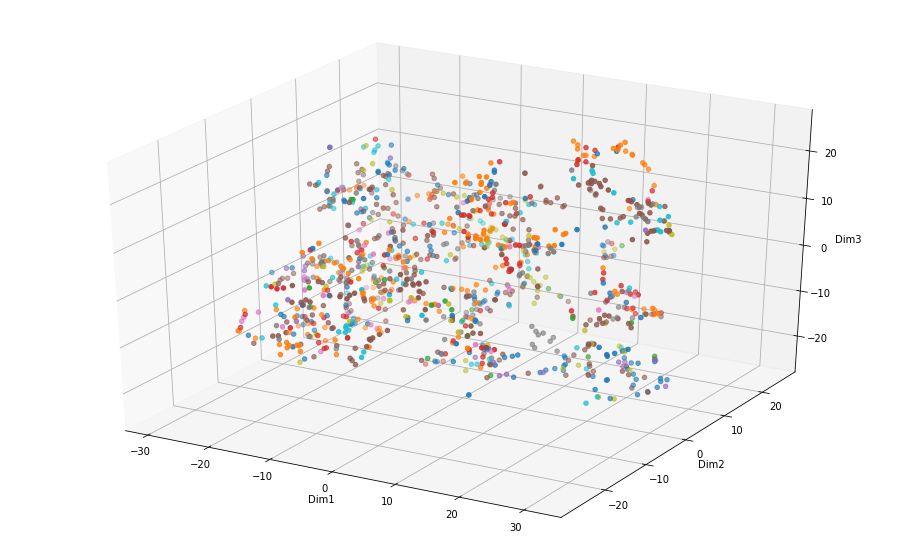

In [90]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=store_state_color_df_3d["X"], 
    ys=store_state_color_df_3d["Y"], 
    zs=store_state_color_df_3d["Z"], 
    c= store_state_color_df_3d["state_num"], 
    cmap='tab10'
)
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
plt.show()

## Find similar stores through KNN from embeddings

In [108]:
# Some functions to get KNN 
# Borrowed code from https://github.com/fastai/fastai/blob/master/courses/dl2/devise.ipynb
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [140]:
knn_indices = create_index(weight_matrix_store)

In [ ]:
store_963 = weight_matrix_store[964]

close_to_store_963, _ = get_knn(knn_indices, store_963)
close_to_store_963

In [132]:
# Test the store distance
weight_matrix_state = learn.model.embeds[13].weight.cpu().detach().numpy()
knn_indices = create_index(weight_matrix_state) 
Berlin_idx = weight_matrix_state[1]
idx, distance = get_knn(knn_indices, Berlin_idx)
close_to_Berlin = [states_names[i] for i in idx]

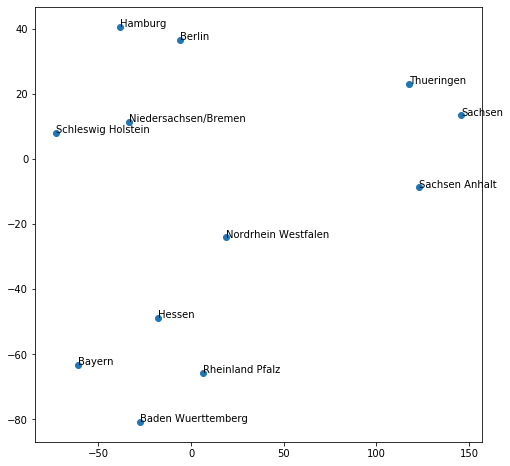

In [138]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
Y = tsne.fit_transform(learn.model.embeds[13].weight.cpu().detach().numpy()[1:])
plt.figure(figsize=(8,8))
plt.scatter(Y[:, 0], -Y[:, 1])
for i, txt in enumerate(states_names[1:]):
    plt.annotate(txt, (Y[i, 0], -Y[i, 1]))

In [134]:
close_to_Berlin

['Berlin',
 'Hamburg',
 'Niedersachsen/Bremen',
 'Bayern',
 'Hessen',
 '#NA#',
 'Sachsen',
 'Schleswig Holstein',
 'Baden Wuerttemberg',
 'Thueringen']

In [266]:
def gen_similar_disimilar_store(knn_order):
    close_random_stores = list(knn_order[:3]) + list(np.random.choice(range(1115), 3))
    print(close_random_stores)
    df_inner = train_df[train_df.Store.isin(close_random_stores)]
    start_date = "07-31-2014" ; end_date = "07-31-2015"
    mask = (df_inner['Date'] > start_date) & (df_inner['Date'] <= end_date)
    df_inner = df_inner.loc[mask]
    return df_inner, close_random_stores
    



In [259]:
store_125 = weight_matrix_store[125]

close_to_store_125, _ = get_knn(knn_indices, store_125)
close_to_store_125

array([ 125,  320, 1033,  513,   25,  788,  211,  906,  831,  336],
      dtype=int32)

In [337]:
df_125, store_selected = gen_similar_disimilar_store(close_to_store_125)
store_selected
type(store_selected)

[125, 320, 1033, 755, 730, 392]


list

In [343]:
%%R
# load the ggplot2 library
library(ggplot2)
df_125$Date = as.Date(df_125$Date , format = "%m/%d/%y")


df_125$Store = as.factor(df_125$Store)
# You need the following tweak to make sure the levels are correct with colors in ggplot
df_125$Store1<- factor(df_125$Store, levels = c(125, 320, 1033, 755, 730, 392))



# factor(c("small", "large", "large", "small", "medium"),
#                 levels = c("small", "medium", "large"))
# df_125$Store = relevel(df_125$Store, c(125, 320, 1033, 1016, 1020, 416))

p = ggplot(df_125, aes(x= Date, y= Sales, color = Store1))+
    geom_line()+
    theme_minimal()+
    scale_x_date(date_labels = "%b/%Y")+
    scale_color_manual(values = c("#CC79A7", "#E7B800", "#FC4E07",
                                 "#999999","#999999","#999999"))




ggsave("same_store_plot_125.png", width = 20, height = 8)

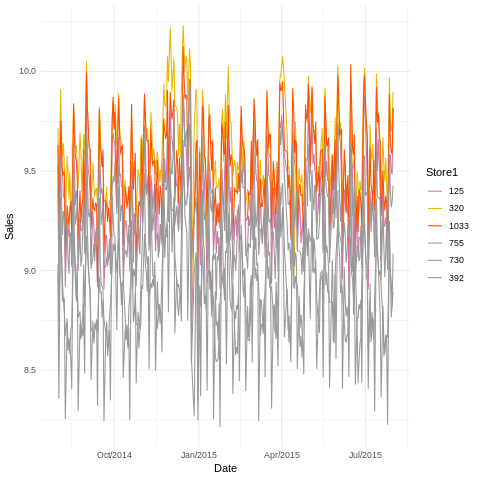

In [344]:
%%R
p

In [230]:
# The distances fro the closest to furtherest among the top 10 close stores to Store 963
print(close_to_store_963)
close_random_stores = list(close_to_store_963[:3]) + np.random.choice(range(1115), 3)

close_random_stores

[ 964  129  528  713   64  983  252  645 1080  820]


[964, 129, 528, 1, 2, 3]

In [231]:
df_close_to_963 = train_df[train_df.Store.isin(close_random_stores)]
df_close_to_963.shape

(4517, 93)

In [232]:
print(f'The original date range is from, {df_close_to_963.Date.max()} to {df_close_to_963.Date.min()}')
# We want to select a smaller range to view more clearly
start_date = "07-31-2014"
end_date = "07-31-2015"
mask = (df_close_to_963['Date'] > start_date) & (df_close_to_963['Date'] <= end_date)

df_close_to_963 = df_close_to_963.loc[mask]
df_close_to_963.shape

The original date range is from, 2015-07-31 00:00:00 to 2013-01-02 00:00:00


(1686, 93)

In [237]:
%%R
# load the ggplot2 library
library(ggplot2)
df_close_to_963$Date = as.Date(df_close_to_963$Date , format = "%m/%d/%y")


df_close_to_963$Store = as.factor(df_close_to_963$Store)
p = ggplot(
df_close_to_963, aes(x= Date, y= Sales, color = Store))+
    geom_line()+
    theme_minimal()+
    scale_x_date(date_labels = "%b/%Y")+
    scale_color_manual(values = c("#999999","#999999","#999999","#CC79A7", "#E7B800", "#FC4E07"))


ggsave("same_store_plot.png", width = 20, height = 8)

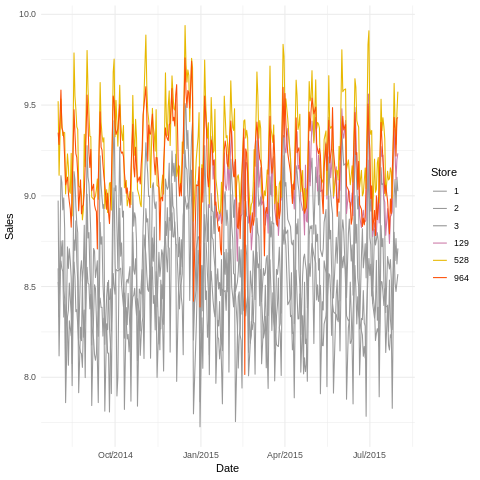

In [238]:
%%R
p # The obj resides in the R env

In [69]:
learn.dls.train_ds["Store"]

41395     1115
41396        1
41397        2
41398        3
41399        4
          ... 
844333     682
844334     733
844335     769
844336     948
844337    1097
Name: Store, Length: 802943, dtype: int16

In [0]:
train_df_copy = learn.dls.train_ds

In [82]:
state_dict = {i:j for i, j in zip(range(13), states_names)}
state_dict

{0: '#NA#',
 1: 'Berlin',
 2: 'Baden Wuerttemberg',
 3: 'Bayern',
 4: 'Niedersachsen/Bremen',
 5: 'Hessen',
 6: 'Hamburg',
 7: 'Nordrhein Westfalen',
 8: 'Rheinland Pfalz',
 9: 'Schleswig Holstein',
 10: 'Sachsen',
 11: 'Sachsen Anhalt',
 12: 'Thueringen'}

In [2]:
state_dict

NameError: ignored

In [94]:
train_df_copy["State"]

41395      5
41396      5
41397     12
41398      7
41399      1
          ..
844333     1
844334     7
844335     7
844336     2
844337     8
Name: State, Length: 802943, dtype: int8

In [0]:
train_df_copy['state_name'] = train_df_copy["State"].map(state_dict)

In [97]:
train_df_copy['state_name']

41395                  Hessen
41396                  Hessen
41397              Thueringen
41398     Nordrhein Westfalen
41399                  Berlin
                 ...         
844333                 Berlin
844334    Nordrhein Westfalen
844335    Nordrhein Westfalen
844336     Baden Wuerttemberg
844337        Rheinland Pfalz
Name: state_name, Length: 802943, dtype: object

In [67]:
X = weight_pca[:,0]
Y = weight_pca[:,1]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(learn.dls.train_ds.classes["Store"], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=13)
plt.show()

(#13) ['#na#','BE','BW','BY','HB,NI','HE','HH','NW','RP','SH'...]

In [72]:
# Add the state full name below corresponding to the abbreviations
print(learn.dls.train_ds.classes["State"])

states_names = ["#NA#", 'Berlin', 'Baden Wuerttemberg', 'Bayern', 'Niedersachsen/Bremen', 
                'Hessen', 'Hamburg', 'Nordrhein Westfalen', 'Rheinland Pfalz',
                'Schleswig Holstein', 'Sachsen', 'Sachsen Anhalt', 'Thueringen']

(#13) ['#na#','BE','BW','BY','HB,NI','HE','HH','NW','RP','SH'...]


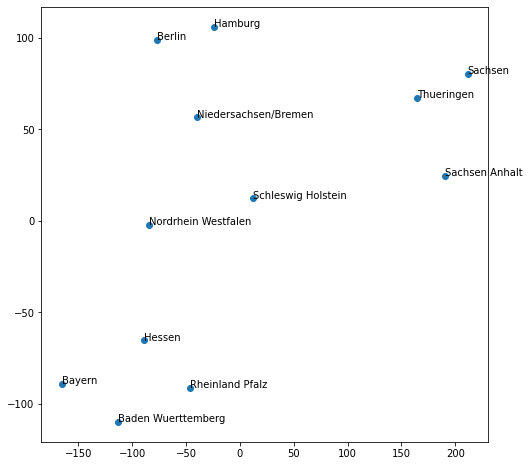

In [124]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
Y = tsne.fit_transform(learn.model.embeds[13].weight.cpu().detach().numpy()[1:])
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], Y[:, 1])
for i, txt in enumerate(states_names[1:]):
    plt.annotate(txt, (-Y[i, 0], Y[i, 1]))

#plt.show()
plt.savefig('state_embedding.pdf')



In [0]:
learn.dls.train_ds.classes

{'Assortment': (#4) ['#na#','a','b','c'],
 'CloudCover_na': (#3) ['#na#',False,True],
 'CompetitionDistance_na': (#3) ['#na#',False,True],
 'CompetitionMonthsOpen': (#26) ['#na#',0,1,2,3,4,5,6,7,8...],
 'CompetitionOpenSinceYear': (#24) ['#na#',1900,1961,1990,1994,1995,1998,1999,2000,2001...],
 'Day': (#32) ['#na#',1,2,3,4,5,6,7,8,9...],
 'DayOfWeek': (#8) ['#na#',1,2,3,4,5,6,7],
 'Events': (#22) ['#na#','Fog','Fog-Rain','Fog-Rain-Hail','Fog-Rain-Hail-Thunderstorm','Fog-Rain-Snow','Fog-Rain-Snow-Hail','Fog-Rain-Thunderstorm','Fog-Snow','Fog-Snow-Hail'...],
 'Month': (#13) ['#na#',1,2,3,4,5,6,7,8,9...],
 'Promo': (#3) ['#na#',0,1],
 'Promo2SinceYear': (#9) ['#na#',1900,2009,2010,2011,2012,2013,2014,2015],
 'Promo2Weeks': (#27) ['#na#',0,1,2,3,4,5,6,7,8...],
 'PromoInterval': (#4) ['#na#','Feb,May,Aug,Nov','Jan,Apr,Jul,Oct','Mar,Jun,Sept,Dec'],
 'Promo_bw': (#7) ['#na#',0.0,1.0,2.0,3.0,4.0,5.0],
 'Promo_fw': (#7) ['#na#',0.0,1.0,2.0,3.0,4.0,5.0],
 'SchoolHoliday': (#3) ['#na#',0,1],
 'Sc

In [0]:
learn.model.embeds

ModuleList(
  (0): Embedding(1116, 81)
  (1): Embedding(8, 5)
  (2): Embedding(4, 3)
  (3): Embedding(13, 7)
  (4): Embedding(32, 11)
  (5): Embedding(3, 3)
  (6): Embedding(26, 10)
  (7): Embedding(27, 10)
  (8): Embedding(5, 4)
  (9): Embedding(4, 3)
  (10): Embedding(4, 3)
  (11): Embedding(24, 9)
  (12): Embedding(9, 5)
  (13): Embedding(13, 7)
  (14): Embedding(53, 15)
  (15): Embedding(22, 9)
  (16): Embedding(7, 5)
  (17): Embedding(7, 5)
  (18): Embedding(4, 3)
  (19): Embedding(4, 3)
  (20): Embedding(9, 5)
  (21): Embedding(9, 5)
  (22): Embedding(3, 3)
  (23): Embedding(3, 3)
  (24): Embedding(3, 3)
  (25): Embedding(3, 3)
)

In [0]:
import csv
import torch
from collections import OrderedDict 
from fastai.basic_train import Learner

defaultlr = 1e-3

def write_encoding_dict(filename, learner, cat_names, cat):
    classes = learner.data.label_list.train.x.classes[cat]
    weight_matrix = learner.model.embeds[cat_names.index(cat)].weight
    with open(filename, 'w') as csvFile:
        writer = csv.writer(csvFile, lineterminator='\n')
        for i in range(len(classes)):
            writer.writerow([classes[i],*weight_matrix[i].tolist()])
        
def get_encoding_dict(filename):
    with open(filename, 'r') as csvFile:
        reader = csv.reader(csvFile)
        lines = list(reader)
        d = OrderedDict()
        for i in range(len(lines)):
            d[lines[i][0]] = [float(lines[i][j]) for j in range(1,len(lines[i]))]
        return d

def load_embed_weights(filename, learner, cat_names, cat):
    encodings = get_encoding_dict(filename)
    classes = learner.data.label_list.train.x.classes[cat]
    weight_matrix = learner.model.embeds[cat_names.index(cat)].weight
    emb_dim=weight_matrix.shape[1]
    with torch.no_grad():
        for i, value in enumerate(classes):
            try: 
                enc = encodings[value]
                for j in range(emb_dim):
                    weight_matrix[i][j] = enc[j]
            except KeyError:
                for j in range(emb_dim):
                    weight_matrix[i][j] = np.random.normal(scale=0.6)
                    
def freeze_embedding(learner:Learner,index=0):
    learner.model.embeds[index].weight.requires_grad = False
    learner.create_opt(defaultlr)
                    
def unfreeze_embedding(learner:Learner,index=0):
    learner.model.embeds[index].weight.requires_grad = True
    learner.create_opt(defaultlr)

## Inference on a test set:
Now that we have a model, we want to make our final competitions that would be submitted to a competition, as such, we can only make the predictions and submit them as a CSV.

We'll practice bringing in an exported model just to show that you do not need the original data. 

In [0]:
learn.export('myModel')

In [0]:
del learn

In [0]:
learn = load_learner('myModel')

Now we generate our `test_dl` from our `test_df`

In [0]:
dl = learn.dls.test_dl(test_df)

#We need to tell the `Learner` to return the predictions for the test set we added

raw_test_preds = learn.get_preds(dl=dl)

Let's take a peek

In [0]:
raw_test_preds

(tensor([[ 8.3808],
         [ 8.8781],
         [ 9.1845],
         ...,
         [ 8.7501],
         [10.0406],
         [ 8.9215]]), None)

You'll notice `[0]` contains our predictions, and `[1]` contains any labels (if we had any). This is nice because if we accidently run `learn.validate()` on a non-labeled test set, we get the following:

In [0]:
learn.validate(dl=dl)

(#2) [None,None]

Still runs, just there are no labels so it's `None`

Now back to our predictions! We need to undo our `log` transform first:

In [0]:
np.exp(raw_test_preds[0])

tensor([[ 4362.4321],
        [ 7173.3774],
        [ 9745.0059],
        ...,
        [ 6311.3501],
        [22939.8164],
        [ 7490.9766]])

In [0]:
test_preds = np.exp(raw_test_preds[0]).numpy().T[0]

(If you want to learn about what `T` does, compare below):

In [0]:
raw_test_preds[0].numpy()

array([[ 8.380785],
       [ 8.878132],
       [ 9.18451 ],
       ...,
       [ 8.750105],
       [10.040629],
       [ 8.921454]], dtype=float32)

In [0]:
test_preds

array([ 4362.432 ,  7173.3774,  9745.006 , ...,  6311.35  , 22939.816 ,
        7490.9766], dtype=float32)

Now we can submit to Kaggle!

In [0]:
test_df['Sales'] = test_preds
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission.csv', index=False)

# Permutation Importance

Permutation importance is a technique in which we shuffle each column in a dataframe and analyze how changing a particular column affected our `y` values. The more that it was affected, the more "important" we can (generally) call a variable in our neural network. Let's build a quick algorithm to do this:

In [0]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

And now we can simply call `PermutationImportance` to run it!

Getting base error


Calculating Permutation Importance


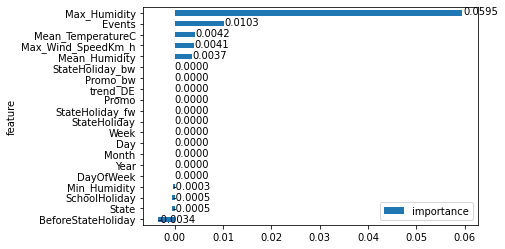

In [0]:
res = PermutationImportance(learn, train_df.iloc[:1000], bs=64)

In [0]:
res.importance

{'AfterStateHoliday': -0.006495955086819835,
 'Assortment': -0.15894991142484757,
 'BeforeStateHoliday': -0.0034450730077863977,
 'CloudCover': -0.021922465471671267,
 'CompetitionDistance': -0.07073883242654737,
 'CompetitionMonthsOpen': -0.048707575175682846,
 'CompetitionOpenSinceYear': -0.006830320781063511,
 'Day': 0.0,
 'DayOfWeek': 0.0,
 'Events': 0.010310428429607058,
 'Max_Humidity': 0.05946607822128924,
 'Max_TemperatureC': -0.029806386487200524,
 'Max_Wind_SpeedKm_h': 0.004062584161248675,
 'Mean_Humidity': 0.0036539491262186446,
 'Mean_TemperatureC': 0.0041852054038987,
 'Mean_Wind_SpeedKm_h': -0.017164310518782103,
 'Min_Humidity': -0.0003381559916355307,
 'Min_TemperatureC': -0.012325842237373623,
 'Month': 0.0,
 'Promo': 0.0,
 'Promo2SinceYear': -0.026129080933810448,
 'Promo2Weeks': -0.3059371320786493,
 'PromoInterval': -0.11177023585996265,
 'Promo_bw': 0.0,
 'Promo_fw': -0.0034969078856317715,
 'SchoolHoliday': -0.00045760157971400057,
 'SchoolHoliday_bw': -0.0616699